## Piecewise constant 1D DG, no projection step for Shallow Water Equations with LLF Flux, time-stepping with AB2+FE

The Shallow water equations are

#### \begin{align*} h_t + (hu)_x &= 0\\ (hu)_t + (hu^2+\frac{1}{2}gh^2)_x &= 0 \end{align*}
Where $h$ is the depth, $u$ is velocity, and $g$ is a constant for the force of gravity.

We may write the shallow water equations in the canonical form $q_t + f(q)_x = 0$ if we define
#### $$ q = \begin{bmatrix} h\\ hu \end{bmatrix},\quad f = \begin{bmatrix} hu \\ hu^2 + \frac{1}{2}gh^2 \end{bmatrix} $$

Then, in terms of the conserved quantities, the flux is
#### $$ f(q) = \begin{bmatrix} q_2 \\ \frac{q_2^2}{q_1}+\frac{1}{2}gq_1^2 \end{bmatrix} $$

So the flux Jacobian is
#### $$ \mathbb{J}(f) = \begin{bmatrix} 0 & 1 \\ -\left(\frac{q_2}{q_1}\right)^2+gq_1 & 2\frac{q_2}{q_1} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -u^2+gh & 2u \end{bmatrix} $$

Which has eigenvalues $\lambda_\pm = u \pm \sqrt{gh}$ and associated eigenvectors $r_\pm = \begin{bmatrix} 1\\ u\pm\sqrt{gh}
\end{bmatrix}$.

### Spatial Discretization
We use the vectorization from the scalar 1st order DG method. That is, given a partition of the real line, with cells centered at $x_j$, the evolution of one cell is now given by
$$\boxed{ \frac{d}{dt}\mathbf{q}_j = \tilde{\mathbf{f}}(\mathbf{q}_{j-1},\mathbf{q}_j) - \tilde{\mathbf{f}}(\mathbf{q}_j,\mathbf{q}_{j+1}) }$$

Recall that the numerical flux was chosen to be the Local Lax-Friedrichs flux
$$ \tilde{f}(u_i,u_e) = \frac{1}{2}\left( f(u_e)+f(u_i) - \alpha(u_e-u_i) \right) $$

However, as the Jacobian was $1\times 1$, the eigenvector was really an eigenscalar and was 1, simplifying the Roe-splitting flux. In the System of equations case, we have

$$\boxed{ \tilde{\mathbf{f}}(\mathbf{q}^-,\mathbf{q}^+) = \frac{1}{2}\left(\mathbf{f}(\mathbf{q}^-)+\mathbf{f}(\mathbf{q}^+) - R|\Lambda|L(\mathbf{q}^--\mathbf{q}^+)\right)}$$

For simplicity of implementation, the eigenvalues of the Jacobian are evaluated at the average of $\mathbf{q}^-$ and $\mathbf{q}^+$.

Hence the matrices in the primitive variables are $$R_p = \begin{bmatrix} 1 & 1 \\ u+\sqrt{gh} & u-\sqrt{gh} \end{bmatrix},\ |\Lambda|_p = \begin{bmatrix} |u+\sqrt{gh}| & 0 \\ 0 & |u-\sqrt{gh}| \end{bmatrix},\ L_p = \frac{1}{-2\sqrt{gh}}\begin{bmatrix} u-\sqrt{gh} & -1 \\ -u-\sqrt{gh} & 1 \end{bmatrix} $$

Then, the matrices in the corresponding conserved variables:
$$ R = \begin{bmatrix} 1 & 1 \\ q_2/q_1+\sqrt{gq_1} & q_2/q_1 - \sqrt{gq_1} \end{bmatrix}$$ $$|\Lambda| = \begin{bmatrix} |q_2/q_1+\sqrt{gq_1}| & 0 \\ 0 & |q_2/q_1 - \sqrt{gq_1}| \end{bmatrix}$$  $$L = \frac{-1}{2\sqrt{gq_1}} \begin{bmatrix} q_2/q_1-\sqrt{gq_1} & -1 \\ -q_2/q_1 - \sqrt{gq_1} & 1 \end{bmatrix} $$

### Temporal Discretization
Let us initially use the same temporal discretization as in the scalar conservation case.

To timestep an equation of the form $\partial_t u = F(u)$, the Second-order Adams Bashforth Method is used, that is
$$ \boxed{u^{n+1} = u^n + \frac{\Delta t}{2}\left( 3F(u^n) - F(u^{n-1}) \right) }$$
Which is a 2-step method, and hence requires a single second order step, which can be done with a single Forward Euler step
$$ u^1 = u^0 + \Delta tF(u^0) $$

### Implementation
Again, consider a uniform grid partitioning the interveral $[-l,l]$ of the real line with $N+3$ cells; the cells are centered at each $x_j$.

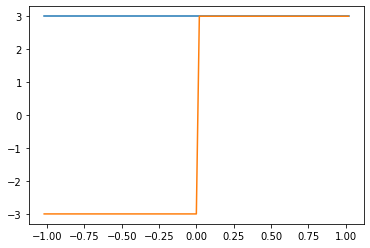

In [37]:
### Imports
import matplotlib.pyplot as plt
from IPython.display import clear_output # to 'animate' output of time-stepping loop
import numpy as np
from domain import Mesh, Cell1d # custom classes for DG implementation

### Parameters
g = 10 # Set g equal to one for convenience
l = 1
h = 0.02
dt = h/2
T = 4

# IC parameters
hl = 3.0
hr = 3.0
ul = -1.0
ur = 1.0

def IC(x):
    if x > 0:
        return np.array([hr, hr*ur])
    return np.array([hl, hl*ul])


### Spatial discretization
N = int(2*l/h)
x = np.linspace(-l-h,l+h,N+3)
msh = Mesh(1, [Cell1d(xi, h) for xi in x])
msh.impose_IC(IC)

# plot Initial Conditions
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(msh.x,[u[0] for u in msh.u])
ax1.plot(msh.x,[u[1] for u in msh.u])


### Flux Definition
def f(q): # Shallow Water Equations flux in conserved variables
    return np.array([q[1], q[1]**2/q[0]+0.5*g*q[0]**2])

def numf(cellm, cellp):
    q = (cellm.u + cellp.u)/2
    R = np.array([ [ 1, 1], [ q[1]/q[0]+np.sqrt(g*q[0]), q[1]/q[0]-np.sqrt(g*q[0])] ])
    Lm = np.array([ [abs(q[1]/q[0]+np.sqrt(g*q[0])), 0], [0 , abs(q[1]/q[0]-np.sqrt(g*q[0]))] ])
    L = (-1/(2*np.sqrt(g*q[0]))) * np.array( 
        [ [ q[1]/q[0]-np.sqrt(g*q[0]), -1], [ -q[1]/q[0]-np.sqrt(g*q[0]), 1] ])
    
    return 0.5*( f(cellm.u) + f(cellp.u) - 
                np.matmul(R*Lm*L, cellp.u-cellm.u) )

msh.set_flux(f)
msh.set_numflux(numf)

# Semi-discrete from
def F(cellm,cell,cellp):
    du_dt = numf(cellm,cell) - numf(cell,cellp)
    return du_dt

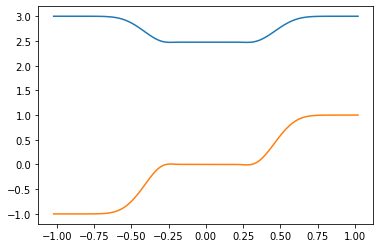

In [38]:
### Time stepping
def ab2(u,Fn1,Fn0): # 2nd Order Adams-Bashforth
    return u + 0.5*dt*(3*Fn1-Fn0)

def fe(u,Fn0): # Forward Euler
    return u + dt*Fn0

# Initial Time step so that AB2 can be used
for j in range(1,N+2):
    cell = msh.cells[j]
    cell.F0 = F(msh.cells[j-1],cell,msh.cells[j+1])
    cell.u = fe(cell.u,cell.F0)
msh.retrieve_u()


# Time stepping with AB2
t = dt
while t < T:
    clear_output(wait=True)
    t += dt
    for j in range(1,N+2):
        cell = msh.cells[j]
        cell.F1 = F(msh.cells[j-1],msh.cells[j],msh.cells[j+1])
        u1 = ab2(cell.u, cell.F1, cell.F0)
        cell.F0 = cell.F1
        cell.u = u1
    msh.retrieve_u()
    
    plt.plot(msh.x,[u[0] for u in msh.u])
    plt.plot(msh.x,[u[1]/u[0] for u in msh.u])
    plt.show()
 
